In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data1=pd.read_csv('/content/drive/MyDrive/dosdata/data1.csv')
data2=pd.read_csv('/content/drive/MyDrive/dosdata/data2.csv')
data3=pd.read_csv('/content/drive/MyDrive/dosdata/data3.csv')

train_data=pd.concat([data1,data2,data3]).reset_index(drop=True)

train_data = train_data.drop(columns='Unnamed: 0')

train_data["Label"] = train_data["Label"].replace(["Benign","Anomaly"],[0,1])
for label, index in zip(['Benign', 'Anomaly'], [0, 1]):
    print(f"{label}: {index}")

Mounted at /content/drive
Benign: 0
Anomaly: 1


In [ ]:
print(train_data["Label"].value_counts())

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X = train_data.drop("Label", axis=1)
y = train_data["Label"]

undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

print(Counter(y))

Label
0    1567950
1    1000448
Name: count, dtype: int64
Counter({0: 1000448, 1: 1000448})


In [ ]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_fold_performance(estimator, X, y, fold_idx, fold):

    train_idx, val_idx = fold
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

    estimator.fit(X_fold_train, y_fold_train)
    y_pred = estimator.predict(X_fold_val)
    y_pred_proba = estimator.predict_proba(X_fold_val)[:, 1]

    metrics = {
        'fold': fold_idx + 1,
        'accuracy': accuracy_score(y_fold_val, y_pred),
        'precision': precision_score(y_fold_val, y_pred),
        'recall': recall_score(y_fold_val, y_pred),
        'f1': f1_score(y_fold_val, y_pred),
        'auc_roc': roc_auc_score(y_fold_val, y_pred_proba)
    }

    cm = confusion_matrix(y_fold_val, y_pred)
    metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp'] = cm.ravel()

    return metrics, y_pred_proba, y_fold_val

def optimize_qda_detailed(X, y, cv=5):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    qda_classifier = QuadraticDiscriminantAnalysis()
    param_grid = {'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}

    best_results = {}
    all_metrics = []

    print(f"\n{'-'*50}")
    print(f"Evaluating Quadratic Discriminant Analysis...")

    grid_search = GridSearchCV(
        estimator=qda_classifier,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    print(f"\nBest Parameters for QDA:", grid_search.best_params_)
    print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    fold_metrics = []
    fold_predictions = []
    fold_true_values = []

    for fold_idx, fold in enumerate(skf.split(X, y)):
        metrics, y_pred_proba, y_true = evaluate_fold_performance(
            best_model, X, y, fold_idx, fold
        )
        metrics['model_type'] = 'QDA'
        fold_metrics.append(metrics)
        fold_predictions.append(y_pred_proba)
        fold_true_values.append(y_true)

        print(f"\nFold {fold_idx + 1} Metrics:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1']:.4f}")
        print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
        print("\nConfusion Matrix:")
        print(f"TN: {metrics['tn']}, FP: {metrics['fp']}")
        print(f"FN: {metrics['fn']}, TP: {metrics['tp']}")

    all_metrics.extend(fold_metrics)

    plt.figure(figsize=(8, 6))
    for fold_idx in range(cv):
        fpr, tpr, _ = roc_curve(
            fold_true_values[fold_idx],
            fold_predictions[fold_idx]
        )
        plt.plot(
            fpr, tpr,
            label=f'Fold {fold_idx + 1} (AUC = {fold_metrics[fold_idx]["auc_roc"]:.4f})'
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for QDA (All Folds)')
    plt.legend()
    plt.show()

    best_results['qda'] = {
        'model': best_model,
        'params': grid_search.best_params_,
        'score': grid_search.best_score_
    }

    metrics_df = pd.DataFrame(all_metrics)

    print("\nAverage Metrics for QDA:")
    avg_metrics = metrics_df.groupby('model_type').agg({
        'accuracy': ['mean', 'std'],
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'auc_roc': ['mean', 'std']
    })
    print(avg_metrics)

    return best_model, best_results, metrics_df


--------------------------------------------------
Evaluating Quadratic Discriminant Analysis...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters for QDA: {'reg_param': 0.5}
Best Cross-Validation Score: 0.7839

Fold 1 Metrics:
Accuracy: 0.7776
Precision: 0.7002
Recall: 0.9707
F1-Score: 0.8136
AUC-ROC: 0.9688

Confusion Matrix:
TN: 93545, FP: 66531
FN: 4684, TP: 155384

Fold 2 Metrics:
Accuracy: 0.7762
Precision: 0.6986
Recall: 0.9714
F1-Score: 0.8127
AUC-ROC: 0.9695

Confusion Matrix:
TN: 92996, FP: 67079
FN: 4574, TP: 155494

Fold 3 Metrics:
Accuracy: 0.7881
Precision: 0.7111
Recall: 0.9707
F1-Score: 0.8208
AUC-ROC: 0.9695

Confusion Matrix:
TN: 96938, FP: 63138
FN: 4691, TP: 155376

Fold 4 Metrics:
Accuracy: 0.7861
Precision: 0.7086
Recall: 0.9719
F1-Score: 0.8196
AUC-ROC: 0.9700

Confusion Matrix:
TN: 96087, FP: 63989
FN: 4495, TP: 155572

Fold 5 Metrics:
Accuracy: 0.7917
Precision: 0.7153
Recall: 0.9692
F1-Score: 0.8231
AUC-ROC: 0.9687

Confusion Matrix

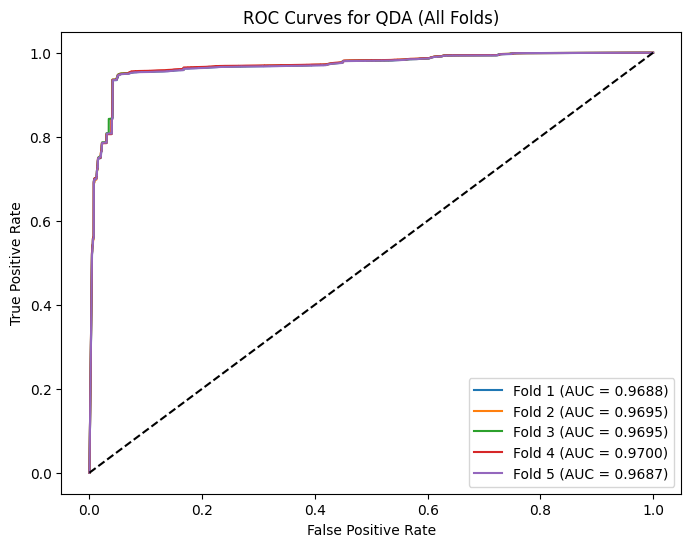


Average Metrics for QDA:
            accuracy           precision              recall            \
                mean       std      mean       std      mean       std   
model_type                                                               
QDA         0.783938  0.006781  0.706747  0.007142  0.970801  0.001014   

                  f1             auc_roc            
                mean       std      mean       std  
model_type                                          
QDA         0.817974  0.004589  0.969304  0.000533  

Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.61      0.75    200069
           1       0.71      0.97      0.82    200111

    accuracy                           0.79    400180
   macro avg       0.83      0.79      0.78    400180
weighted avg       0.83      0.79      0.78    400180



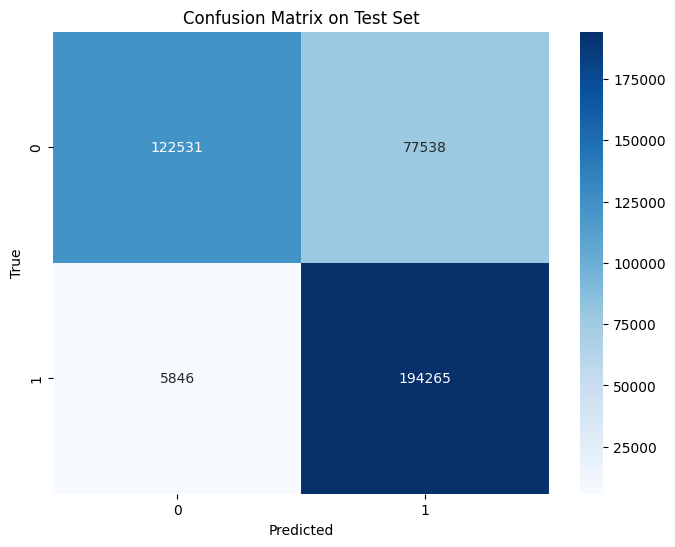

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model, best_results, metrics_df = optimize_qda_detailed(X_train, y_train)

y_pred = best_model.predict(X_test)
print("\nFinal Test Set Performance:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

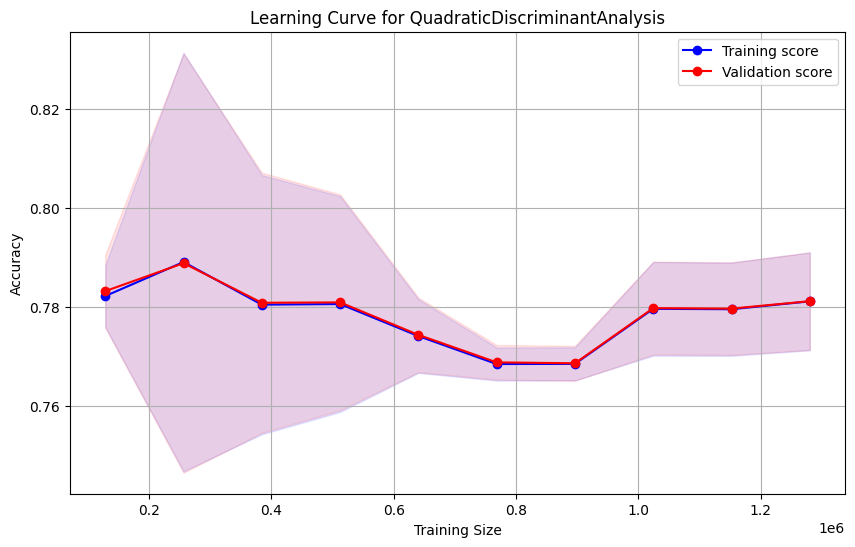

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)):

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='red', alpha=0.1)

    plt.xlabel('Training Size')
    plt.ylabel(scoring.capitalize())
    plt.title(f'Learning Curve for {estimator.__class__.__name__}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

plot_learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy')

In [ ]:
import numpy as np

indices = np.random.choice(len(X_test), size=10, replace=False)
sample_inputs = X_test.iloc[indices]
true_labels = y_test.iloc[indices]

predictions = best_model.predict(sample_inputs)
predicted_labels = predictions

for i in range(len(indices)):
    print(f"Sample Index: {indices[i]}")
    print(f"True Label: {true_labels.iloc[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print("-" * 30)


Sample Index: 373269
True Label: 1
Predicted Label: 1
------------------------------
Sample Index: 165512
True Label: 0
Predicted Label: 1
------------------------------
Sample Index: 276251
True Label: 1
Predicted Label: 1
------------------------------
Sample Index: 103411
True Label: 1
Predicted Label: 1
------------------------------
Sample Index: 124207
True Label: 0
Predicted Label: 0
------------------------------
Sample Index: 334986
True Label: 1
Predicted Label: 1
------------------------------
Sample Index: 89162
True Label: 0
Predicted Label: 0
------------------------------
Sample Index: 24479
True Label: 0
Predicted Label: 0
------------------------------
Sample Index: 270697
True Label: 0
Predicted Label: 0
------------------------------
Sample Index: 161027
True Label: 0
Predicted Label: 0
------------------------------
